In [1]:
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
COLORS = sns.color_palette('colorblind')

## Content Table:
* [Data Metrics](#1-bullet)
* [Basic Model Metrics](#2-bullet)
* [Cross Model Metrics](#3-bullet)
* [Grid Search Model Metrics](#4-bullet)

In [2]:
if os.getenv('CONTAINER_BASE_DIR'):
    API_DIRECTORY_URL = 'http://api:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()
    directory['result'] = {k: v.replace('localhost', 'api') 
                           for k, v in directory['result'].items()}
else:
    API_DIRECTORY_URL = 'http://localhost:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()

In [3]:
raw_df_data = requests.get(directory['result']['get_dataframe_data']).json()
raw_model_data = requests.get(directory['result']['get_model_data']).json()
raw_cross_data = requests.get(directory['result']['get_cross_model_data']).json()
raw_grid_data = requests.get(directory['result']['get_grid_cv_results_model_data']).json()

## Data Metrics <a class="anchor" id="1-bullet"></a>

In [4]:
data_to_create_df = []
for record in raw_df_data['result']:
    data_to_create_df = data_to_create_df + record['message']['data']

In [5]:
df_data = pd.DataFrame(data_to_create_df)

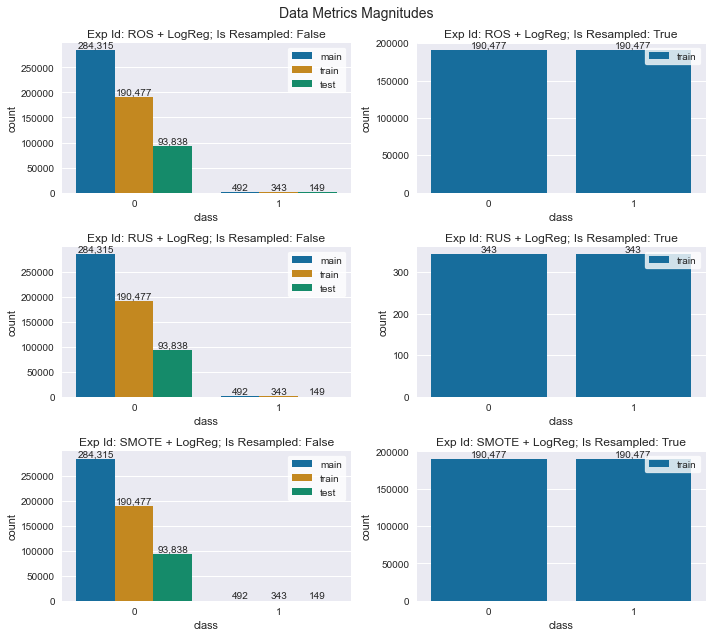

In [6]:
_ = plt.figure(figsize=[10, 9])
plt.suptitle('Data Metrics Magnitudes', fontsize=14)

for i, exp in enumerate(df_data['exp_id'].unique()[:3]):
    data = df_data[df_data['exp_id'] == exp]
    
    index = (i * 2) + 1
    
    plt.subplot(3,2,index)
    ros_log_original = data[~data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_original, 
        x='class', 
        y='count',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{int(value):,}' for value in container.datavalues]
        ax.bar_label(container, labels)
    ax.set_ylabel('count')
    plt.title(f'Exp Id: {exp}; Is Resampled: False')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

    plt.subplot(3,2,index+1)
    ros_log_resampled = data[data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_resampled, 
        x='class', 
        y='count',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{int(value):,}' for value in container.datavalues]
        ax.bar_label(container, labels)
    ax.set_ylabel('count')
    plt.title(f'Exp Id: {exp}; Is Resampled: True')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

plt.tight_layout()

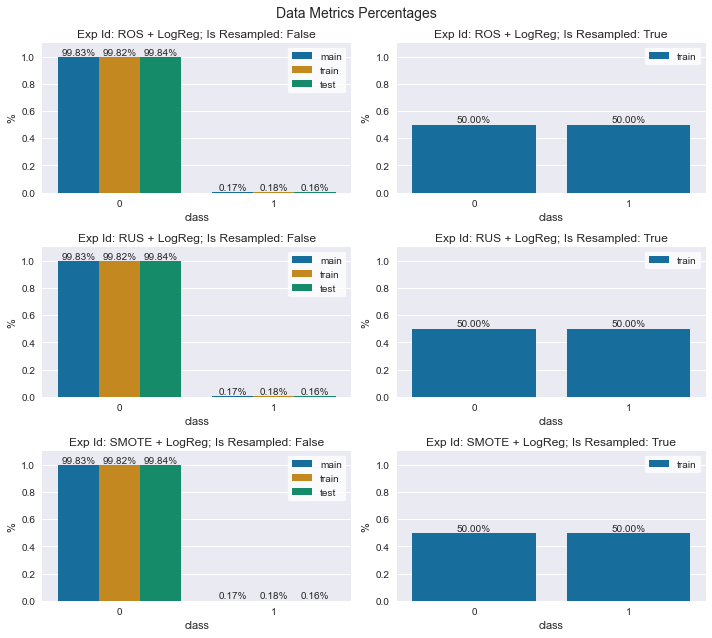

In [7]:
_ = plt.figure(figsize=[10, 9])
plt.suptitle('Data Metrics Percentages', fontsize=14)

for i, exp in enumerate(df_data['exp_id'].unique()[:3]):
    data = df_data[df_data['exp_id'] == exp]
    
    index = (i * 2) + 1
    
    plt.subplot(3,2,index)
    ros_log_original = data[~data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_original, 
        x='class', 
        y='percent',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{value:.2f}%' for value in container.datavalues*100]
        ax.bar_label(container, labels)
    ax.set_ylabel('%')
    plt.ylim([0, 1.1])
    plt.title(f'Exp Id: {exp}; Is Resampled: False')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

    plt.subplot(3,2,index+1)
    ros_log_resampled = data[data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_resampled, 
        x='class', 
        y='percent',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{value:.2f}%' for value in container.datavalues*100]
        ax.bar_label(container, labels)
    ax.set_ylabel('%')
    plt.ylim([0, 1.1])
    plt.title(f'Exp Id: {exp}; Is Resampled: True')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

plt.tight_layout()

## Basic Model Metrics <a class="anchor" id="2-bullet"></a>

In [8]:
data_to_create_df = [record['message']['data'] for record in raw_model_data['result']]
df_model_metric = pd.DataFrame(data_to_create_df)

In [9]:
df_model_metric.drop_duplicates(subset='f_score', keep='first', inplace=True)

for exp in ['LogReg', 'RanFor']:
    mask = (~df_model_metric['is_resampled']) & (df_model_metric['exp_id'].str.contains(exp))
    df_model_metric.loc[mask, 'exp_id'] = exp

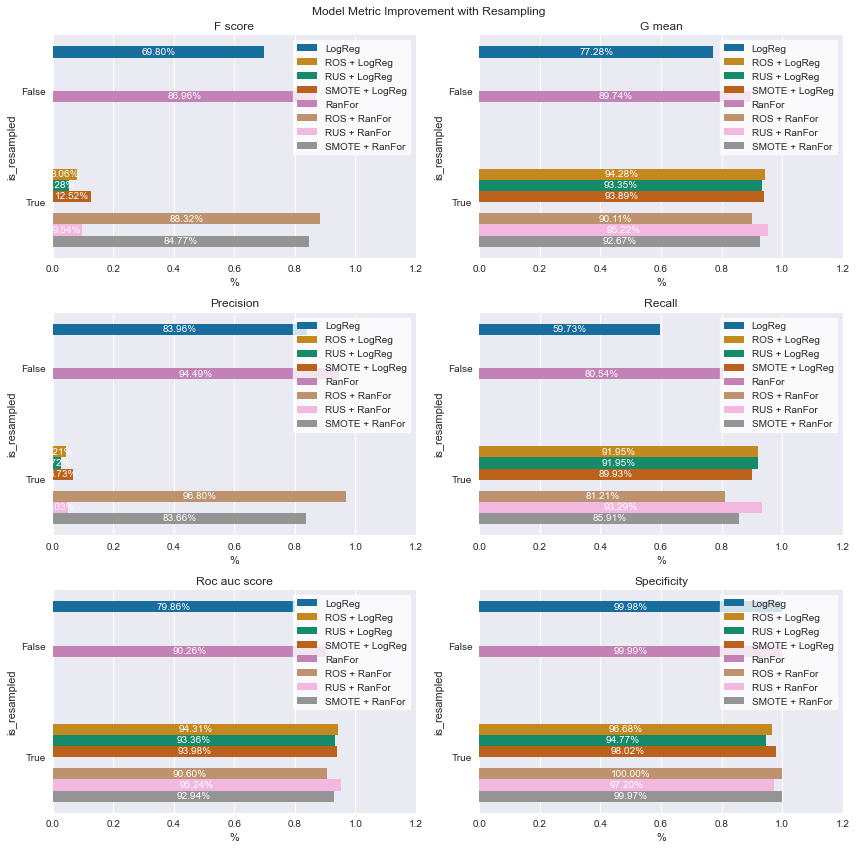

In [10]:
_ = plt.figure(figsize=[12,12])
plt.suptitle('Model Metric Improvement with Resampling')

metric_list = df_model_metric.select_dtypes(include='float64').columns

for i, metric in enumerate(metric_list):
    plt.subplot(3, 2, i+1)
    ax = sns.barplot(
        data=df_model_metric,
        x=metric,
        y='is_resampled',
        hue='exp_id',
        palette='colorblind',
        orient='h')
    for container in ax.containers:
        labels = [f'{value:.2f}%' for value in container.datavalues*100]
        ax.bar_label(container, labels, label_type='center', color='white')
    ax.set_xlabel('%')
    plt.xlim([0,1.2])
    plt.title(metric.replace('_', ' ').capitalize())
    legend = plt.legend(loc='upper right', frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')
  
plt.tight_layout()

## Cross Model Metrics <a class="anchor" id="3-bullet"></a>

In [11]:
cross_data = [record['message']['data'] for record in raw_cross_data['result']]

In [12]:
df = pd.DataFrame()
for cross_record in cross_data:
    df_cross = pd.DataFrame(cross_record)
    df = pd.concat([df, df_cross], ignore_index=True)
    
assert df.shape[0] == cross_data[0].get('fit_time').__len__() * cross_data.__len__()
assert df.shape[1] == cross_data[0].__len__()

df_cross = df.melt(id_vars=['exp_id'], var_name="metrics", value_name="scores")

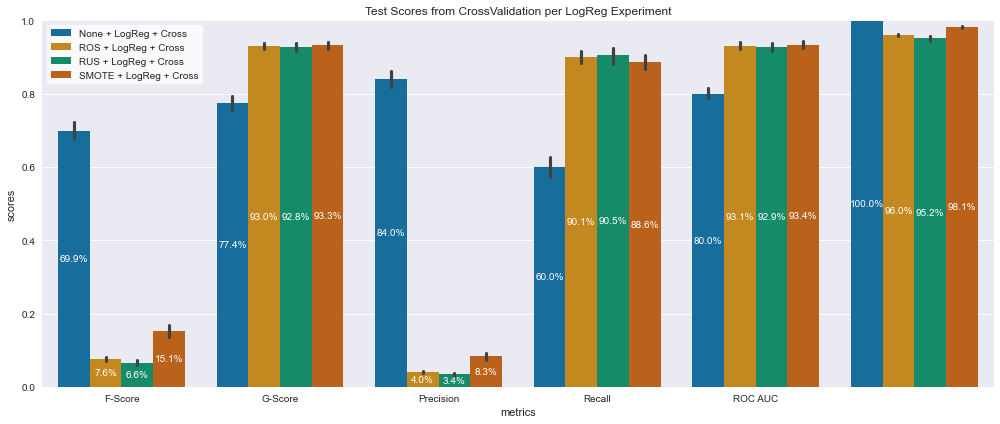

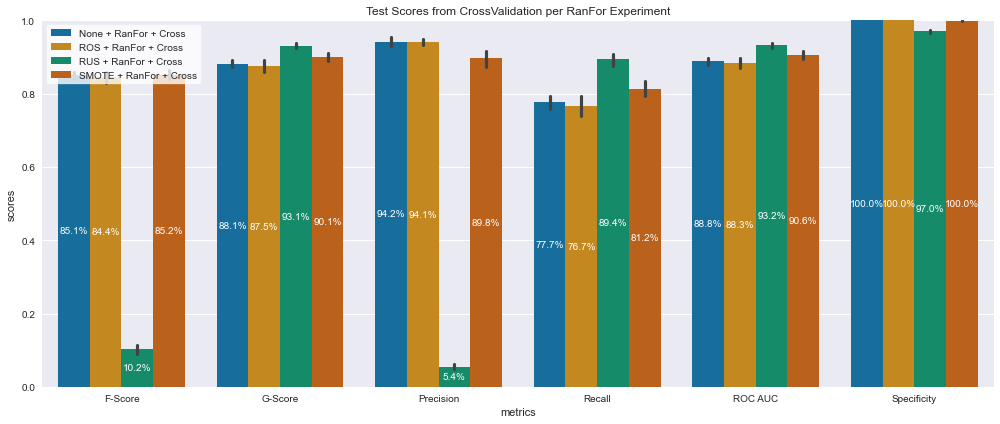

In [13]:
## LogReg
_ = plt.figure(figsize=[14,6])
exp_condition = df_cross['exp_id'].str.contains('LogReg')
metric_condition = ~((df_cross['metrics'].str.contains('fit_time')) | 
                     (df_cross['metrics'].str.contains('score_time')))
mask = exp_condition & metric_condition

ax = sns.barplot(
    data=df_cross[mask],
    x='metrics', 
    y='scores',
    hue='exp_id',
    palette='colorblind')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='center', color='white')
plt.xticks(range(5), ['F-Score', 'G-Score', 'Precision', 'Recall', 'ROC AUC'])
plt.legend(loc='upper left', frameon=True).get_frame().set_color('white')
plt.ylim([0,1])
plt.title('Test Scores from CrossValidation per LogReg Experiment')
plt.tight_layout()


## RanFor
_ = plt.figure(figsize=[14,6])
exp_condition = df_cross['exp_id'].str.contains('RanFor')
metric_condition = ~((df_cross['metrics'].str.contains('fit_time')) | 
                     (df_cross['metrics'].str.contains('score_time')))
mask = exp_condition & metric_condition

ax = sns.barplot(
    data=df_cross[mask],
    x='metrics', 
    y='scores',
    hue='exp_id',
    palette='colorblind')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='center', color='white')
plt.xticks(range(6), ['F-Score', 'G-Score', 'Precision', 'Recall', 'ROC AUC', 'Specificity'])
plt.legend(loc='upper left', frameon=True).get_frame().set_color('white')
plt.ylim([0,1])
plt.title('Test Scores from CrossValidation per RanFor Experiment')
plt.tight_layout()

## Grid Search Model Metrics <a class="anchor" id="4-bullet"></a>

In [14]:
grid_data = [record['message']['data'] for record in raw_grid_data['result']]

In [15]:
df = pd.DataFrame()
for grid_record in grid_data:
    df_grid = pd.DataFrame(grid_record)
    df = pd.concat([df, df_grid], ignore_index=True)

df_grid_melt = df.melt(id_vars=['exp_id'], var_name="metrics", value_name="scores")

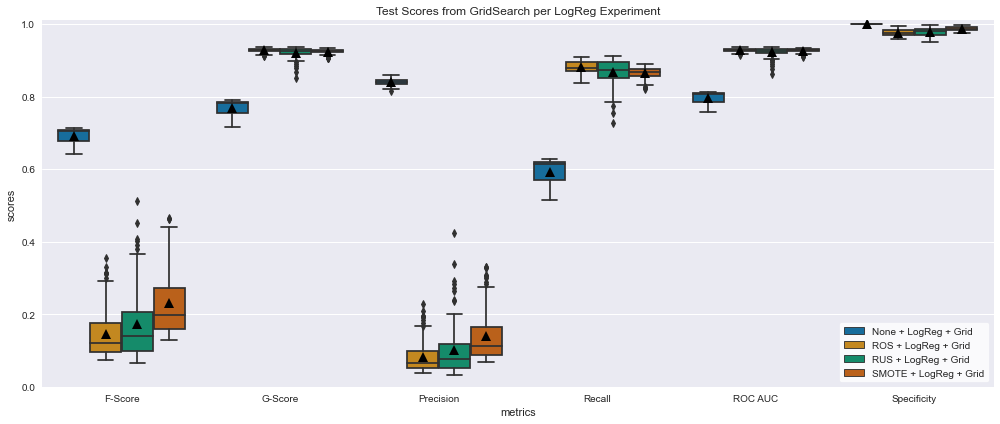

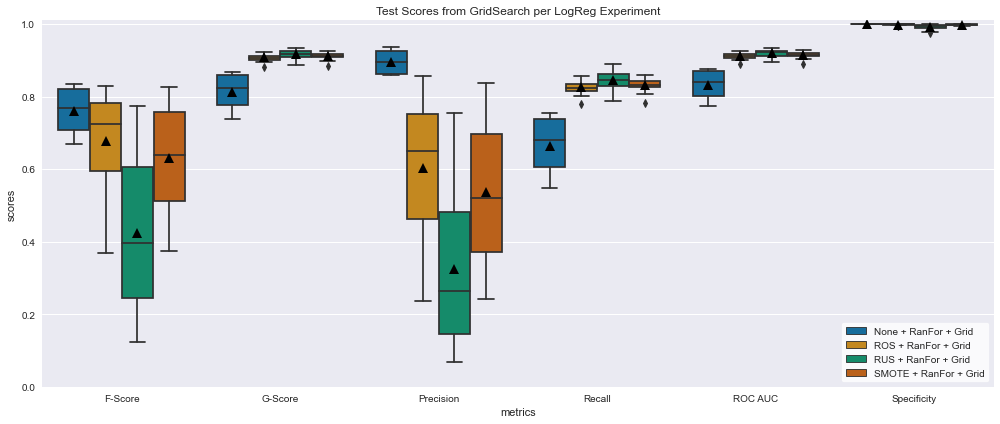

In [16]:
## LogReg
_ = plt.figure(figsize=[14,6])
exp_condition = df_grid_melt['exp_id'].str.contains('LogReg')
metric_condition = df_grid_melt['metrics'].str.contains('mean_test_')
mask = exp_condition & metric_condition
meanprops = {
    'markerfacecolor':'black', 
    'markeredgecolor':'black',
    'markersize':'10',
}
ax = sns.boxplot(
    data=df_grid_melt[mask],
    x='metrics', 
    y='scores',
    hue='exp_id',
    showmeans=True,
    meanprops=meanprops,
    palette='colorblind')
plt.xticks(range(6), ['F-Score', 'G-Score', 'Precision', 'Recall', 'ROC AUC', 'Specificity'])
plt.legend(loc='lower right', frameon=True).get_frame().set_color('white')
plt.ylim([0,1.01])
plt.title('Test Scores from GridSearch per LogReg Experiment')
plt.tight_layout()

## RanFor
_ = plt.figure(figsize=[14,6])
exp_condition = df_grid_melt['exp_id'].str.contains('RanFor')
metric_condition = df_grid_melt['metrics'].str.contains('mean_test_')
mask = exp_condition & metric_condition
meanprops = {
    'markerfacecolor':'black', 
    'markeredgecolor':'black',
    'markersize':'10',
}
ax = sns.boxplot(
    data=df_grid_melt[mask],
    x='metrics', 
    y='scores',
    hue='exp_id',
    showmeans=True,
    meanprops=meanprops,
    palette='colorblind')
plt.xticks(range(6), ['F-Score', 'G-Score', 'Precision', 'Recall', 'ROC AUC', 'Specificity'])
plt.legend(loc='lower right', frameon=True).get_frame().set_color('white')
plt.ylim([0,1.01])
plt.title('Test Scores from GridSearch per LogReg Experiment')
plt.tight_layout()

In [17]:
metrics = [col for col in df.columns if col.startswith('mean_test_')]
mask = df['param_resampling__sampling_strategy'] != ''
cols = ['exp_id', 'param_resampling__sampling_strategy'] + metrics
df.loc[mask, cols].groupby(['exp_id', 'param_resampling__sampling_strategy']).max()

mean_test_f1  \
exp_id                param_resampling__sampling_strategy                 
ROS + LogReg + Grid   0.1                                      0.354262   
                      0.2                                      0.242283   
                      0.3                                      0.187367   
                      0.4                                      0.161090   
                      0.5                                      0.143251   
                      0.6                                      0.119142   
                      0.7                                      0.104950   
                      0.8                                      0.097959   
                      0.9                                      0.090951   
                      1.0                                      0.078713   
ROS + RanFor + Grid   0.1                                      0.827912   
                      0.2                                      0.826821   
                      0.3                                      0.805463   
                      0.4                                      0.789832   
                      0.5                                      0.769174   
                      0.6                                      0.754386   
                      0.7                                      0.737992   
                      0.8                                      0.719380   
                      0.9                                      0.688884   
                      1.0                                      0.655651   
RUS + LogReg + Grid   0.1                                      0.512903   
                      0.2                                      0.407320   
                      0.3                                      0.401125   
                      0.4                                      0.381208   
                      0.5                                      0.299484   
                      0.6                                      0.250445   
                      0.7                                      0.202492   
                      0.8                                      0.188553   
                      0.9                                      0.207613   
                      1.0                                      0.152106   
RUS + RanFor + Grid   0.1                                      0.773137   
                      0.2                                      0.736966   
                      0.3                                      0.709903   
                      0.4                                      0.675317   
                      0.5                                      0.596683   
                      0.6                                      0.559235   
                      0.7                                      0.492847   
                      0.8                                      0.416911   
                      0.9                                      0.347196   
                      1.0                                      0.303825   
SMOTE + LogReg + Grid 0.1                                      0.465450   
                      0.2                                      0.365567   
                      0.3                                      0.304430   
                      0.4                                      0.266036   
                      0.5                                      0.224061   
                      0.6                                      0.211499   
                      0.7                                      0.179014   
                      0.8                                      0.172738   
                      0.9                                      0.150699   
                      1.0                                      0.149890   
SMOTE + RanFor + Grid 0.1                                      0.826895   
                      0.2                                      0.793153   
         

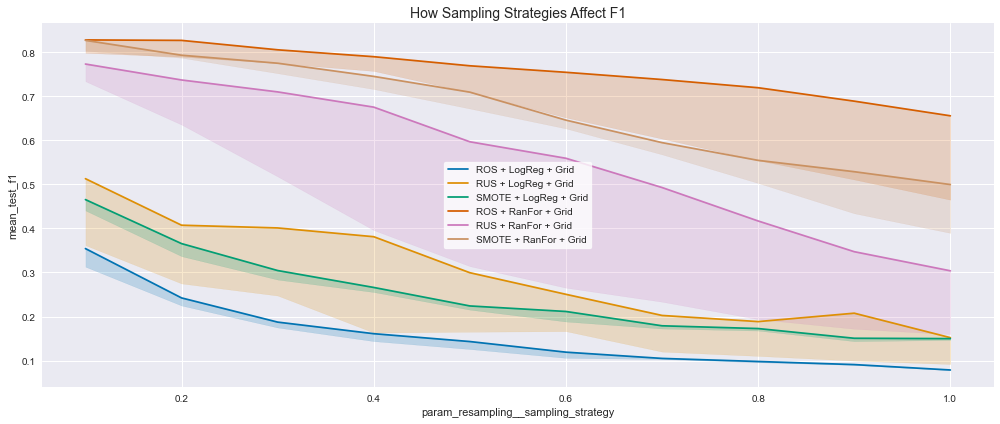

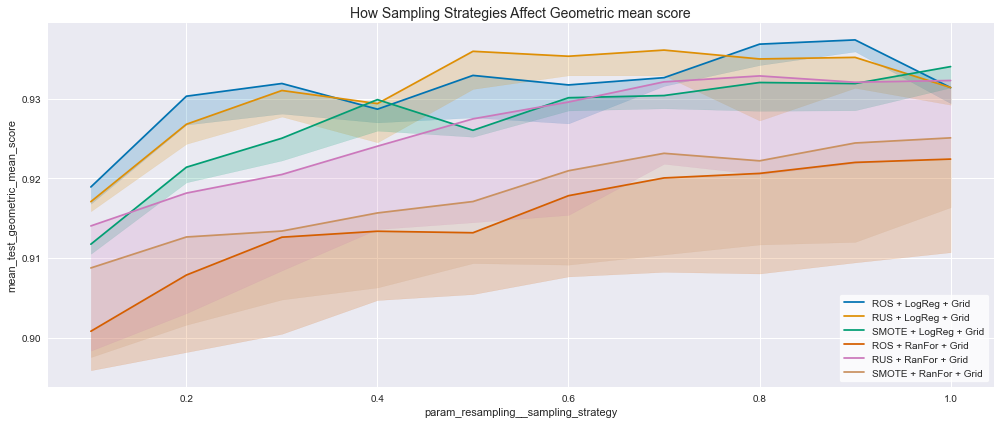

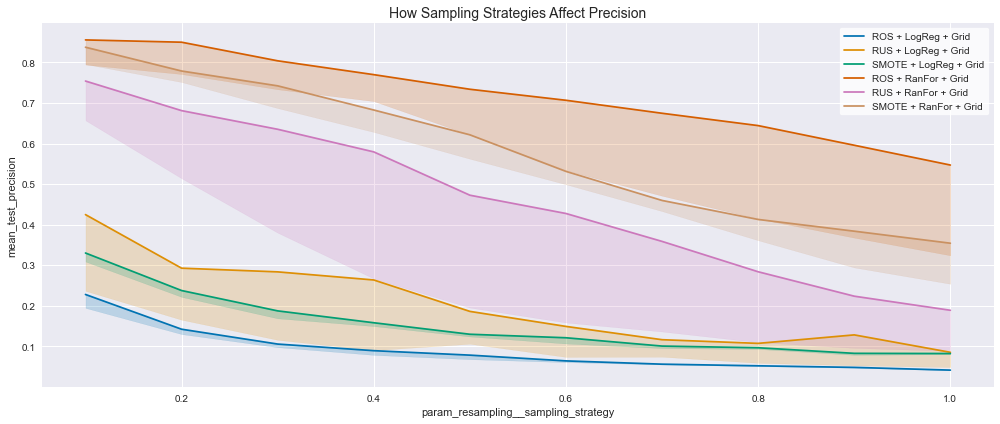

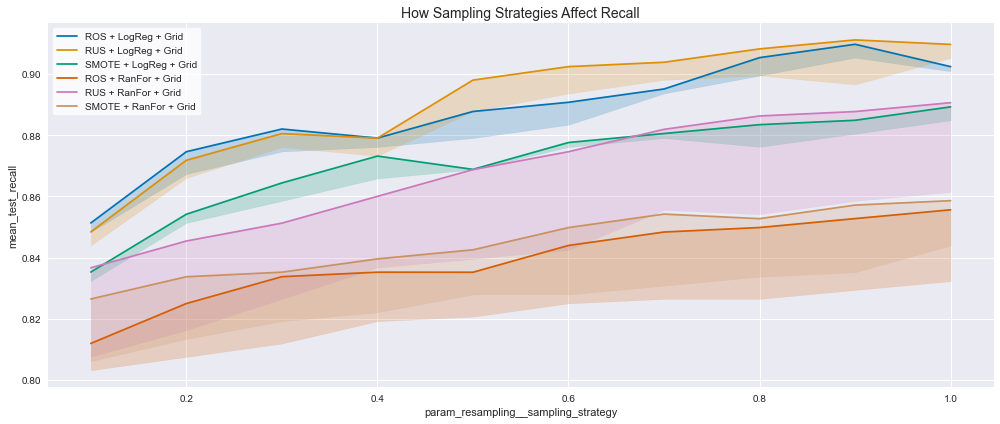

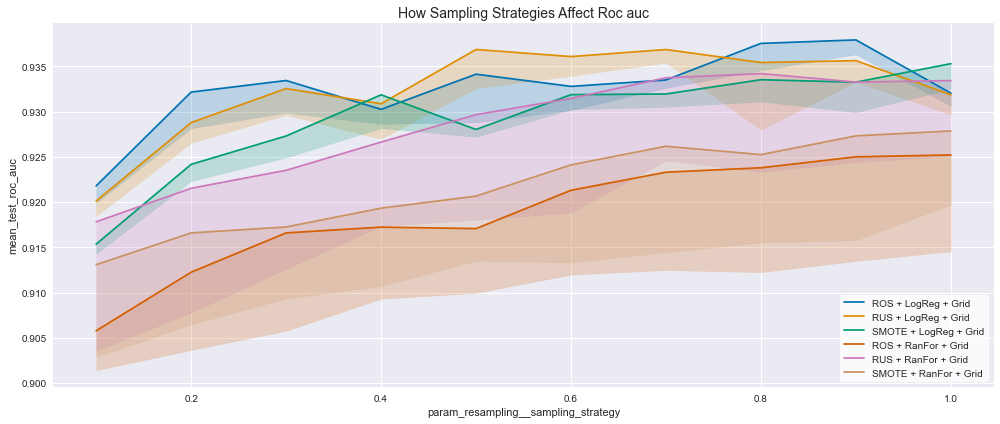

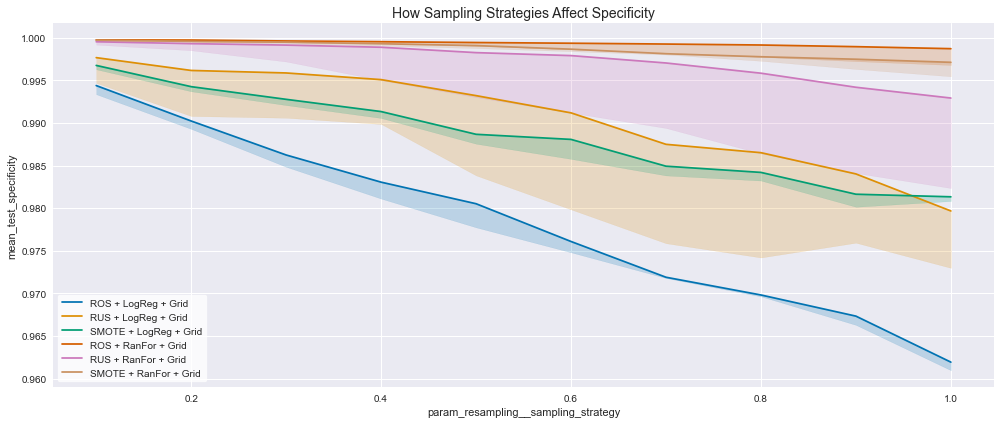

In [18]:
df.loc[df['param_resampling__sampling_strategy'].isnull(), 'param_resampling__sampling_strategy'] = ''

metrics = [col for col in df.columns if col.startswith('mean_test_')]
mask = df['param_resampling__sampling_strategy'] != ''
cols = ['exp_id', 'param_resampling__sampling_strategy'] + metrics

for metric in metrics:
    _ = plt.figure(figsize=[14,6])
    ax = sns.lineplot(
        data=df.loc[mask, cols],
        x='param_resampling__sampling_strategy',
        y=metric,
        hue='exp_id',
        estimator=np.max,
        palette='colorblind')
#     for container in ax.containers:
#         labels = [f'{value:.1f}%' for value in container.datavalues*100]
#         ax.bar_label(container, labels, label_type='center', color='white', rotation=30)
    plt.legend(loc='best', frameon=True).get_frame().set_color('white')
    pretty_metric = metric.replace('mean_test_', '').replace('_', ' ').capitalize()
    plt.title(f'How Sampling Strategies Affect {pretty_metric}', fontsize=14)
#     plt.ylim([0,1.1])
    plt.tight_layout()

In [19]:
metrics = [col for col in df.columns if col.startswith('mean_test_')]
mask = df['param_resampling__sampling_strategy'] != ''
cols = ['exp_id', 'param_estimator__C'] + metrics
df.loc[mask, cols].groupby(['exp_id', 'param_estimator__C']).max()

mean_test_f1  \
exp_id                param_estimator__C                 
ROS + LogReg + Grid   0.001000                0.354262   
                      0.002855                0.313125   
                      0.008149                0.311514   
                      0.023263                0.291661   
                      0.066408                0.313341   
                      0.189574                0.299299   
                      0.541170                0.279571   
                      1.544859                0.330670   
                      4.410059                0.312868   
                      12.589254               0.278731   
RUS + LogReg + Grid   0.001000                0.512903   
                      0.002855                0.452330   
                      0.008149                0.361943   
                      0.023263                0.365981   
                      0.066408                0.312856   
                      0.189574                0.303299   
                      0.541170                0.299227   
                      1.544859                0.281603   
                      4.410059                0.273508   
                      12.589254               0.289484   
SMOTE + LogReg + Grid 0.001000                0.465450   
                      0.002855                0.433782   
                      0.008149                0.440828   
                      0.023263                0.461543   
                      0.066408                0.440351   
                      0.189574                0.415596   
                      0.541170                0.406088   
                      1.544859                0.461592   
                      4.410059                0.437591   
                      12.589254               0.419421   

                                          mean_test_geometric_mean_score  \
exp_id                param_estimator__C                                   
ROS + LogReg + Grid   0.001000                                  0.935656   
                      0.002855                                  0.934585   
                      0.008149                                  0.936818   
                      0.023263                                  0.937349   
                      0.066408                                  0.933936   
                      0.189574                                  0.934831   
                      0.541170                                  0.934228   
                      1.544859                                  0.937084   
                      4.410059                                  0.935555   
                      12.589254                                 0.935902   
RUS + LogReg + Grid   0.001000                                  0.905705   
                      0.002855                                  0.919321   
                      0.008149                                  0.927672   
                      0.023263                                  0.932399   
                      0.066408                                  0.936074   
                      0.189574                                  0.934039   
                      0.541170                                  0.935160   
                      1.544859                                  0.935920   
                      4.410059                                  0.933752   
                      12.589254                                 0.935303   
SMOTE + LogReg + Grid 0.001000                                  0.928779   
                      0.002855                                  0.931879   
                      0.008149                                  0.930014   
                      0.023263                                  0.932010   
                      0.066408                                  0.930681   
                      0.189574                                  0.931479   
                      0.541170                           

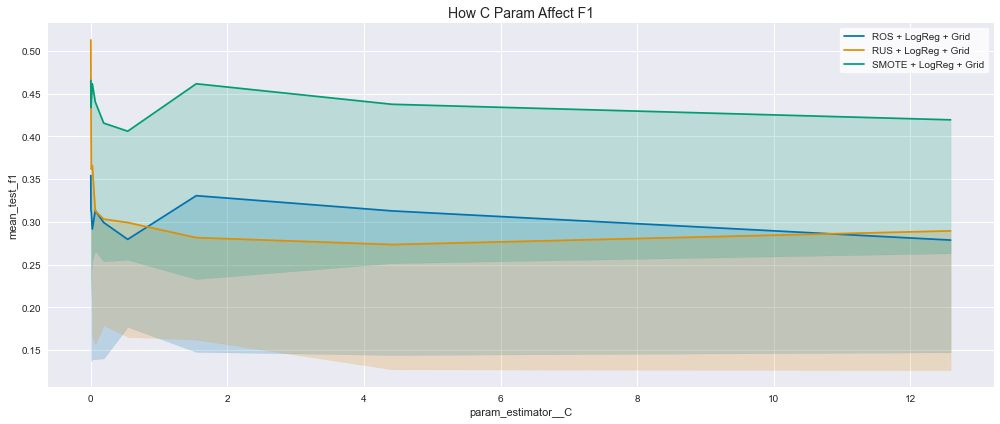

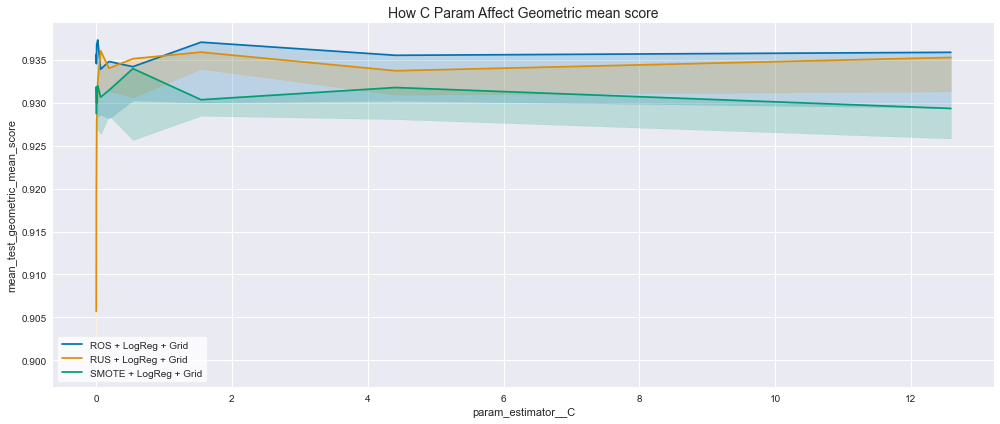

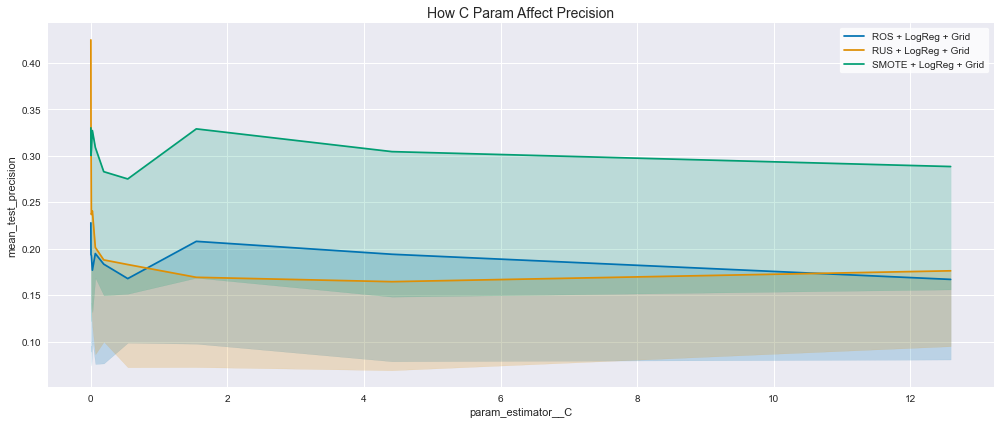

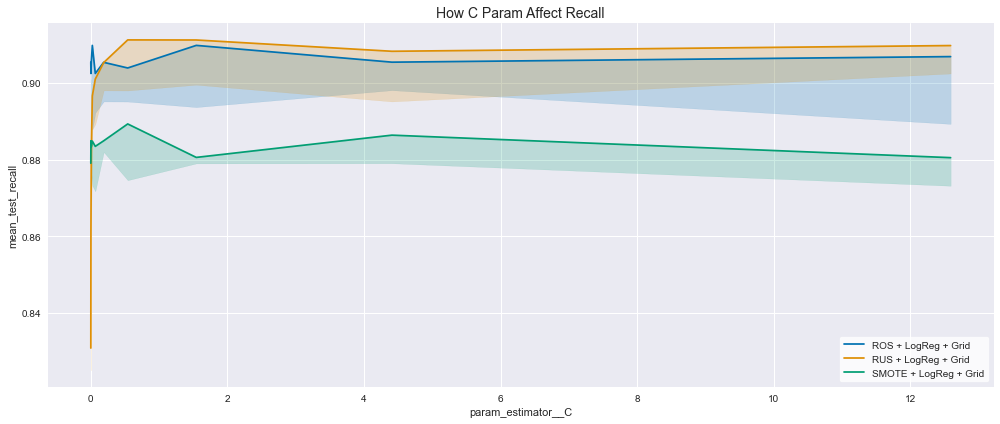

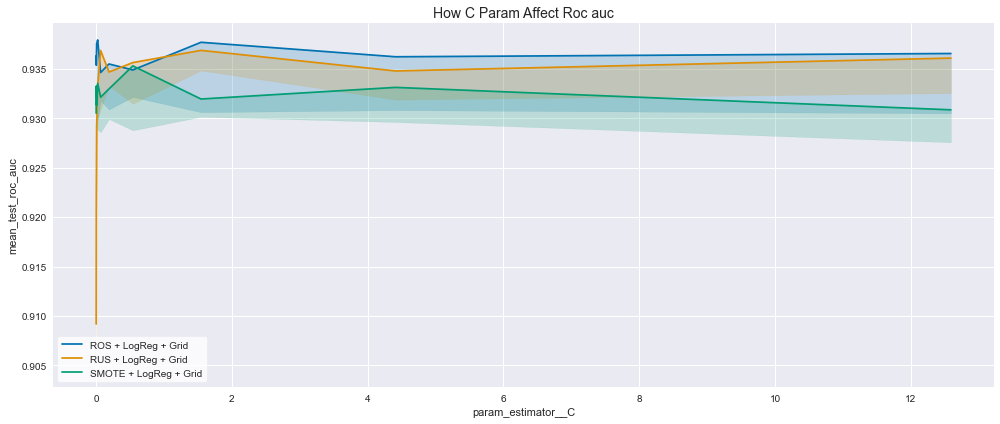

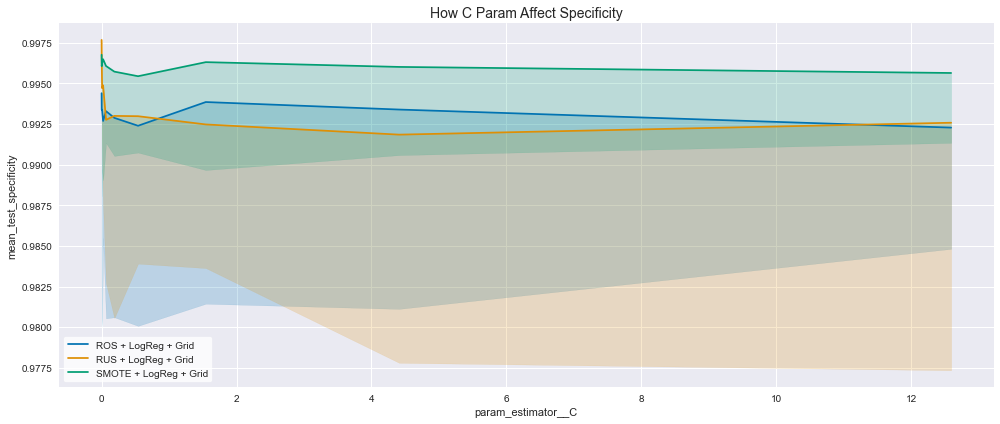

In [20]:
metrics = [col for col in df.columns if col.startswith('mean_test_')]
mask = ~(df['param_estimator__C'].isnull())
cols = ['exp_id', 'param_estimator__C'] + metrics

for metric in metrics:
    _ = plt.figure(figsize=[14,6])
    ax = sns.lineplot(
        data=df.loc[mask, cols],
        x='param_estimator__C',
        y=metric,
        hue='exp_id',
        estimator=np.max,
        palette='colorblind')
    plt.legend(loc='best', frameon=True).get_frame().set_color('white')
    pretty_metric = metric.replace('mean_test_', '').replace('_', ' ').capitalize()
    plt.title(f'How C Param Affect {pretty_metric}', fontsize=14)
    plt.tight_layout()

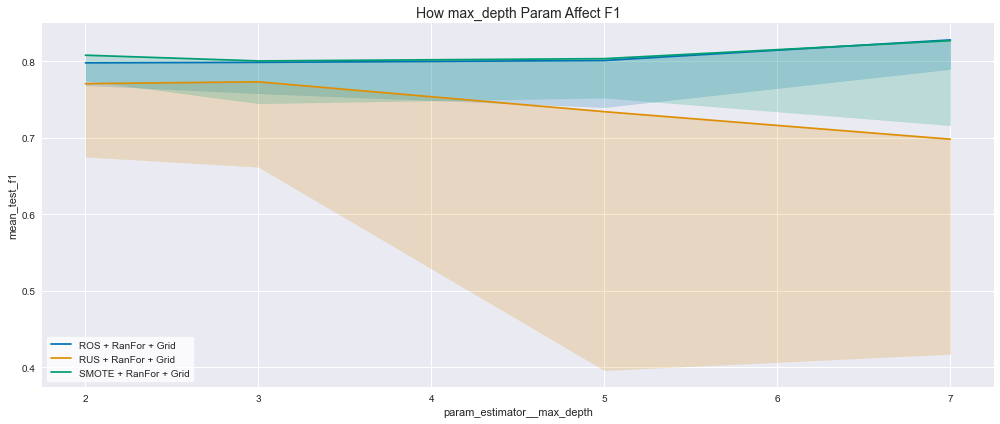

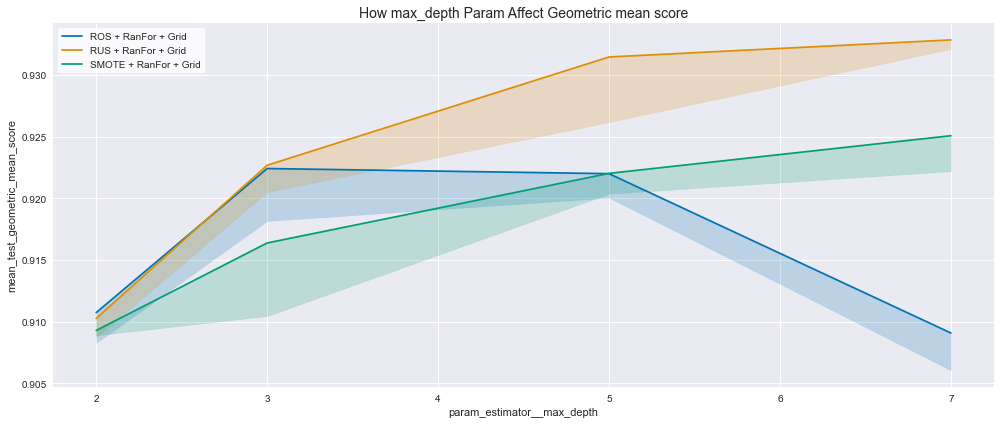

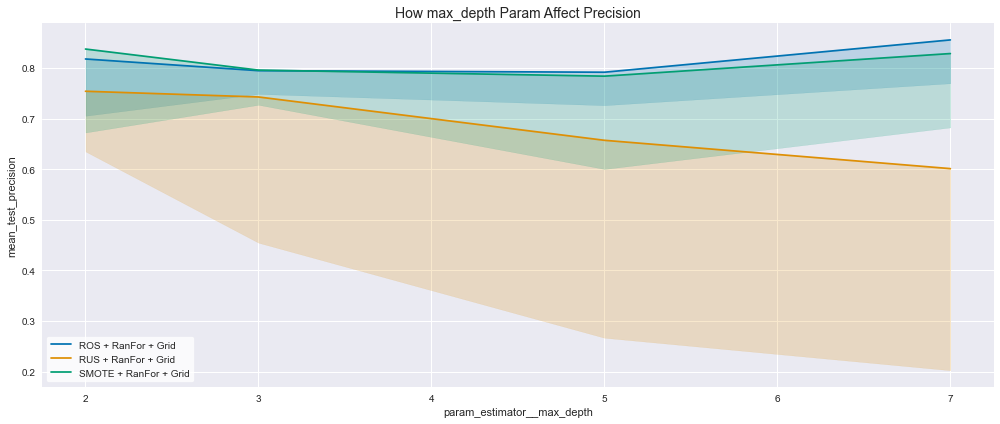

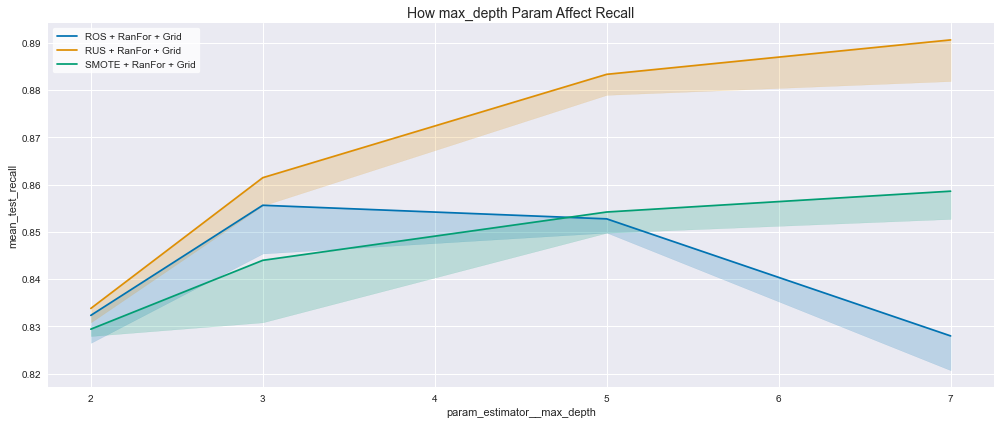

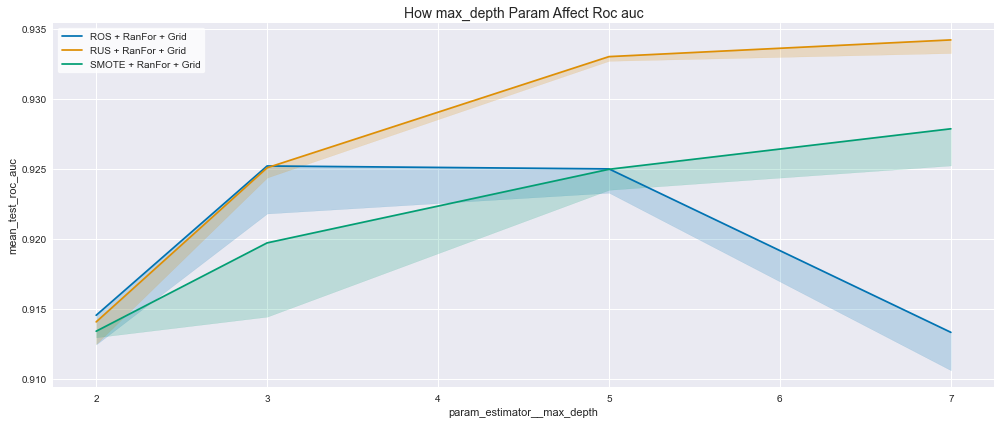

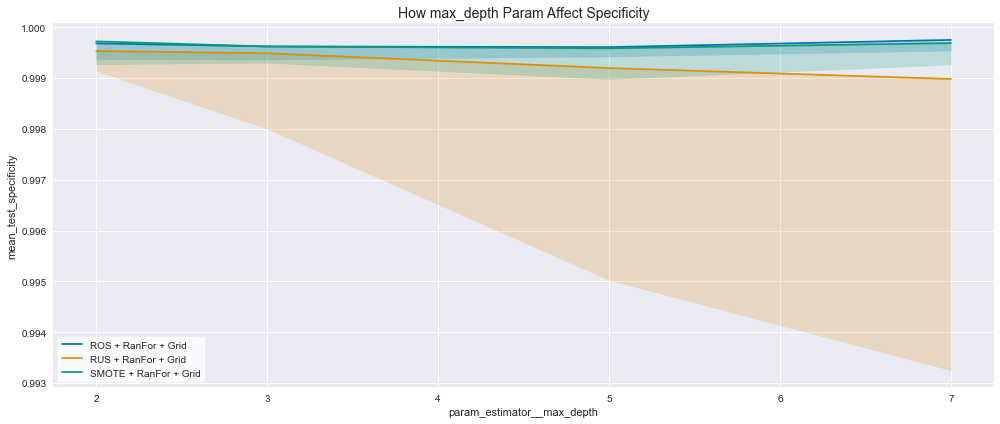

In [21]:
metrics = [col for col in df.columns if col.startswith('mean_test_')]
mask = ~(df['param_estimator__max_depth'].isnull())
cols = ['exp_id', 'param_estimator__max_depth'] + metrics

for metric in metrics:
    _ = plt.figure(figsize=[14,6])
    ax = sns.lineplot(
        data=df.loc[mask, cols],
        x='param_estimator__max_depth',
        y=metric,
        hue='exp_id',
        estimator=np.max,
        palette='colorblind')
    plt.legend(loc='best', frameon=True).get_frame().set_color('white')
    pretty_metric = metric.replace('mean_test_', '').replace('_', ' ').capitalize()
    plt.title(f'How max_depth Param Affect {pretty_metric}', fontsize=14)
    plt.tight_layout()

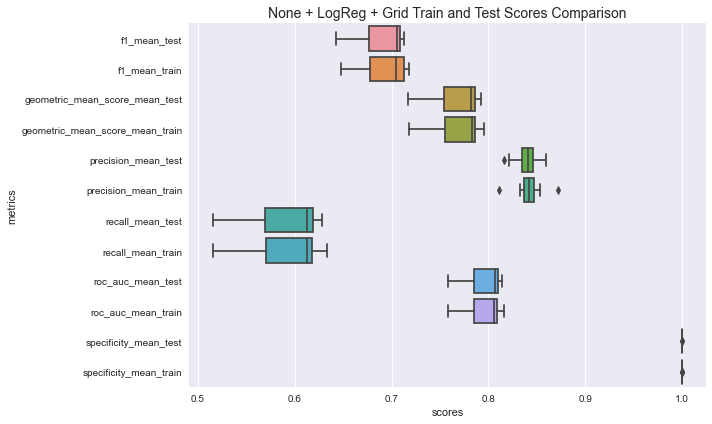

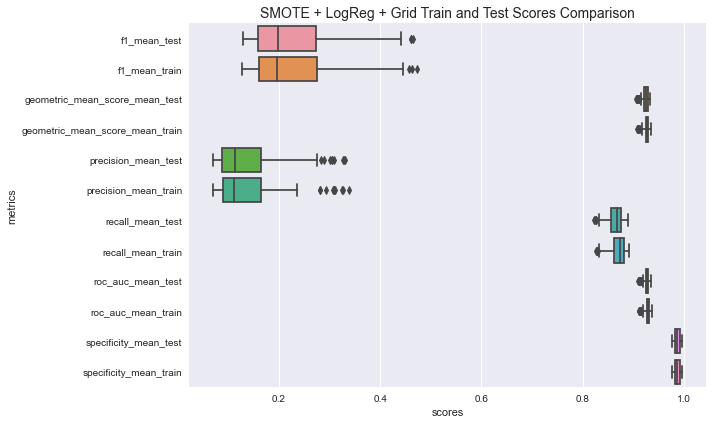

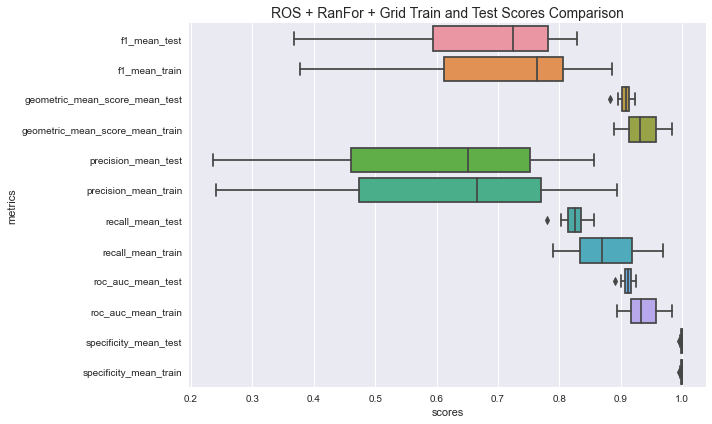

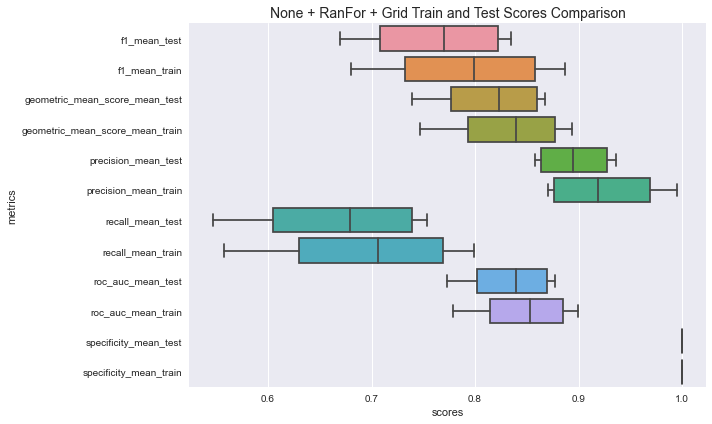

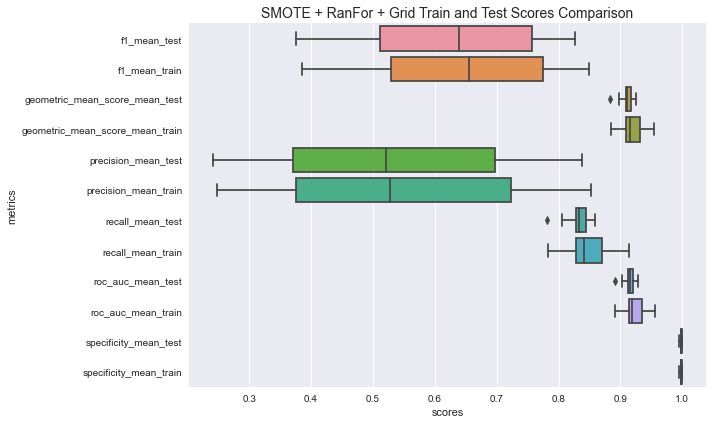

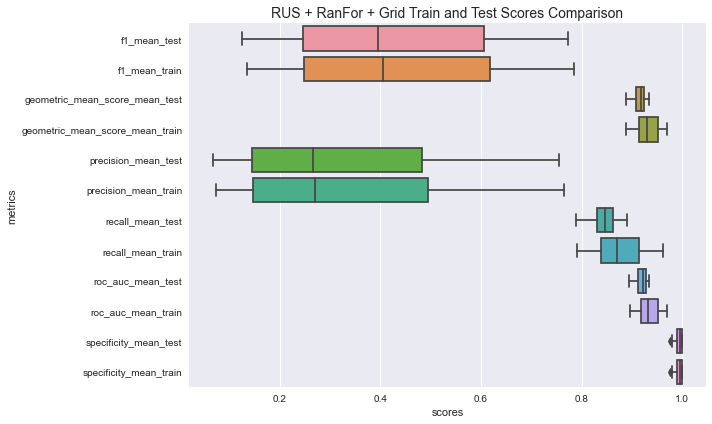

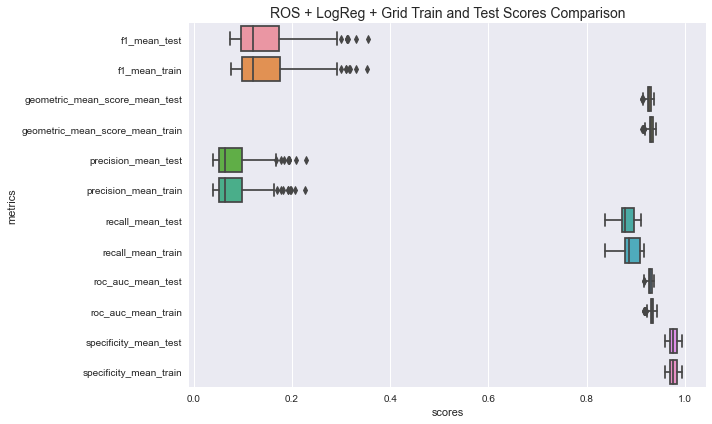

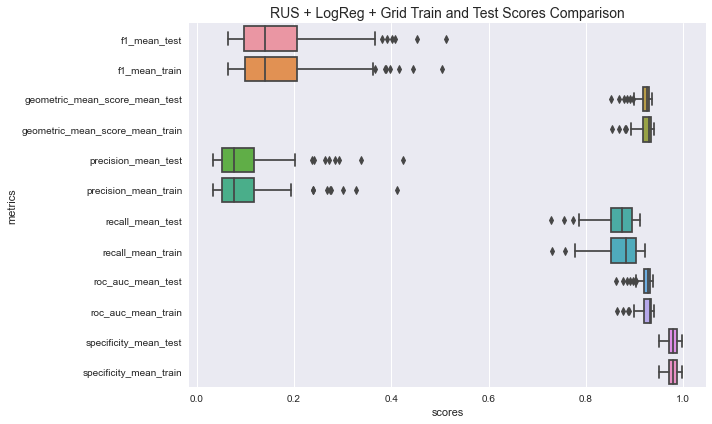

In [22]:
## comparison between train and test scores

metrics = [col for col in df.columns 
           if col.startswith('mean_test_') 
           or col.startswith('mean_train_')]

train_test_comparison = df[['exp_id'] + metrics].melt(
    id_vars=['exp_id'],
    value_vars=metrics,
    var_name='metrics',
    value_name='scores',
    ignore_index=True)

train_test_comparison['metrics'] = train_test_comparison['metrics'].apply(
    lambda string: '_'.join(string.split('_')[2:] + string.split('_')[:2]))

train_test_comparison.sort_values('metrics', inplace=True, ignore_index=True)

for exp in train_test_comparison['exp_id'].unique():
    mask = train_test_comparison['exp_id'] == exp
    train_test_comparison.loc[mask]
    
    _ = plt.figure(figsize=[10,6])
    plt.title(f'{exp} Train and Test Scores Comparison', fontsize=14)
    sns.boxplot(
        data=train_test_comparison.loc[mask],
        x='scores',
        y='metrics',
        orient='h')
    plt.tight_layout()

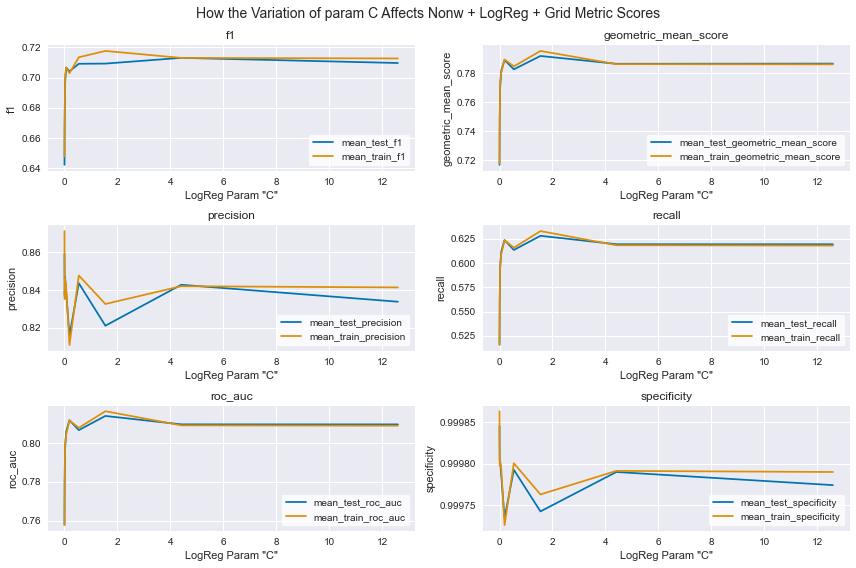

In [23]:
## how C variation does affect LogReg metric scores:

metrics = [col for col in df.columns 
           if col.startswith('mean_test_') 
           or col.startswith('mean_train_')]
mask = df['param_resampling__sampling_strategy'] == ''
cols = ['exp_id', 'param_C'] + metrics

metric_to_plot = [col.replace('mean_test_', '') for col in df.columns 
                  if col.startswith('mean_test_')]
_ = plt.figure(figsize=[12,8])
plt.suptitle('How the Variation of param C Affects Nonw + LogReg + Grid Metric Scores', fontsize=14)
for index, metric in enumerate(metric_to_plot):
    plt.subplot(3,2,index+1)
    sns.lineplot(
        data=df.loc[mask, cols],
        x='param_C',
        y=f'mean_test_{metric}',
        label=f'mean_test_{metric}',
        color=COLORS[0])
    sns.lineplot(
        data=df.loc[mask, cols],
        x='param_C',
        y=f'mean_train_{metric}',
        label=f'mean_train_{metric}',
        color=COLORS[1])
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel('LogReg Param "C"')
    plt.legend(loc='lower right', frameon=True)\
        .get_frame().set_color('white')

plt.tight_layout()

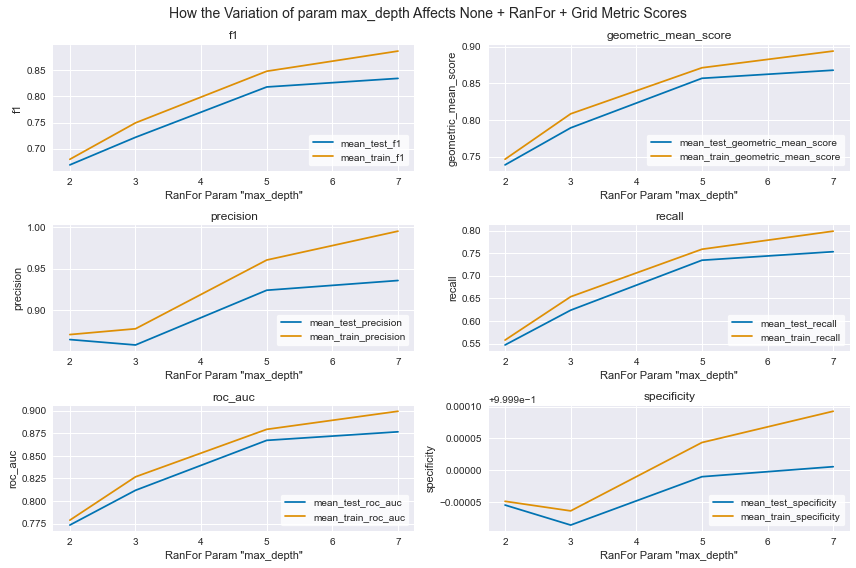

In [24]:
## how C variation does affect LogReg metric scores:

metrics = [col for col in df.columns 
           if col.startswith('mean_test_') 
           or col.startswith('mean_train_')]
mask = df['param_resampling__sampling_strategy'] == ''
cols = ['exp_id', 'param_max_depth'] + metrics

metric_to_plot = [col.replace('mean_test_', '') for col in df.columns 
                  if col.startswith('mean_test_')]
_ = plt.figure(figsize=[12,8])
plt.suptitle('How the Variation of param max_depth Affects None + RanFor + Grid Metric Scores', fontsize=14)
for index, metric in enumerate(metric_to_plot):
    plt.subplot(3,2,index+1)
    sns.lineplot(
        data=df.loc[mask, cols],
        x='param_max_depth',
        y=f'mean_test_{metric}',
        label=f'mean_test_{metric}',
        color=COLORS[0])
    sns.lineplot(
        data=df.loc[mask, cols],
        x='param_max_depth',
        y=f'mean_train_{metric}',
        label=f'mean_train_{metric}',
        color=COLORS[1])
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel('RanFor Param "max_depth"')
    plt.legend(loc='lower right', frameon=True)\
        .get_frame().set_color('white')

plt.tight_layout()